### Sistema Fully Coupled (Girsanov)
$$
\begin{cases}
dS_t =\mu_1(c_1-S_t)dt + \sigma_1dW^1_t\\
dH_t = \mu_2(c_2-H_t)dt + \sigma_2 dW^2_t\\
dV_t = b_V(A_t)dt +\sigma_3 dW^3_t\\
dX_t = V_t dt
\end{cases}
$$
where
$$
b_V(A)=f(A)\Psi(X) + c_3\Psi(-X)-c_4\Psi(X-10)
$$
with
$$\Psi(x)=\max(0,\min(1,x/d,(x_{max}-x)/d))$$ and $f$ a function that we will later choose with care, for now $f=0$.


### Soluzione
$$
    u(t,s,h,v,x) = -\gamma e^s x 
$$

### Equazione backward
$$
 dY_t = -\gamma e^{S_t}\left( X_t \mu_1(c_1-S_t)+V_t +0.5\sigma_1^2X_t \right)dt + Z_t dW_t,
$$
where in the final solution $Z_t = (-\gamma e^{S_t}X_t\sigma_1,0,0,0)$.


In [1]:
## Rete neurale con normalizzazione della loss
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import time
from abc import ABC, abstractmethod

class FBSNN(ABC): # Forward-Backward Stochastic Neural Network
    def __init__(self, Xi, T,
                       M, N, D,
                       layers):

        self.Xi = Xi # initial point
        self.T = T # terminal time

        self.M = M # number of trajectories
        self.N = N # number of time snapshots
        self.D = D # number of dimensions

        # layers
        self.layers = layers # (D+1) --> 1

        # initialize NN
        self.weights, self.biases = self.initialize_NN(layers)

        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))

        # tf placeholders and graph (training)
        self.learning_rate = tf.placeholder(tf.float32, shape=[])
        self.t_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, 1]) # M x (N+1) x 1
        self.W_tf = tf.placeholder(tf.float32, shape=[M, self.N+1, self.D]) # M x (N+1) x D
        self.Xi_tf = tf.placeholder(tf.float32, shape=[1, D]) # 1 x D
        self.const_tf = tf.placeholder(tf.float32, shape=[])

        self.loss, self.X_pred, self.Y_pred, self.Y0_pred, self.Z_pred = self.loss_function(self.t_tf, self.W_tf, self.Xi_tf)

        # optimizers
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)

        # initialize session and variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev), dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1

        H = X
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sin(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, t, X): # M x 1, M x D

        u = self.neural_net(tf.concat([t,X], 1), self.weights, self.biases) # M x 1
        Du = tf.gradients(u, X)[0] # M x D

        return u, Du

    def Dg_tf(self, X): # M x D
        return tf.gradients(self.g_tf(X), X)[0] # M x D

    def loss_function(self, t, W, Xi): # M x (N+1) x 1, M x (N+1) x D, 1 x D
        loss = 0
        X_list = []
        Y_list = []
        Z_list = []

        t0 = t[:,0,:]
        W0 = W[:,0,:]
        X0 = tf.tile(Xi,[self.M,1]) # M x D
        Y0, Du0 = self.net_u(t0,X0) # M x 1, M x D
        sigma0 = self.sigma_tf(t0, X0, Y0)
        Z0 = tf.squeeze(tf.matmul(tf.expand_dims(Du0, 1), sigma0), axis=1)

        X_list.append(X0)
        Y_list.append(Y0)
        Z_list.append(Z0)

        for n in range(0,self.N):
            t1 = t[:,n+1,:]
            W1 = W[:,n+1,:]
            dW = W1 - W0
            sigma_dW = tf.squeeze(tf.matmul(sigma0, tf.expand_dims(dW,-1)), axis=[-1])
            X1 = X0 + self.mu_tf(t0,X0,Y0,Z0)*(t1-t0) + sigma_dW
            # Z = Du*sigma e nella backward compare Z*dW.
            Y1_tilde = Y0 + self.phi_tf(t0,X0,Y0,Z0)*(t1-t0) + tf.reduce_sum(Z0*dW, axis=1, keepdims = True)
            Y1, Du1 = self.net_u(t1,X1)
            sigma1 = self.sigma_tf(t1, X1, Y1)
            Z1 = tf.squeeze(tf.matmul(tf.expand_dims(Du1, 1), sigma1), axis=1)

            loss += tf.reduce_sum(tf.square(Y1 - Y1_tilde))

            t0 = t1
            W0 = W1
            X0 = X1
            Y0 = Y1
            Z0 = Z1
            sigma0 = sigma1

            X_list.append(X0)
            Y_list.append(Y0)
            Z_list.append(Z0)

        loss += tf.reduce_sum(tf.square(Y1 - self.g_tf(X1)))
        Dg = self.Dg_tf(X1)
        Z_terminal = tf.squeeze(tf.matmul(tf.expand_dims(Dg, 1), sigma1), axis=1)
        loss += tf.reduce_sum(tf.square(Z1 - Z_terminal))

        X = tf.stack(X_list,axis=1)
        Y = tf.stack(Y_list,axis=1)
        Z = tf.stack(Z_list,axis=1)

        return loss/self.N, X, Y, Y[0,0,0], Z

    def fetch_minibatch(self):
        T = self.T

        M = self.M
        N = self.N
        D = self.D

        Dt = np.zeros((M,N+1,1)) # M x (N+1) x 1
        DW = np.zeros((M,N+1,D)) # M x (N+1) x D

        dt = T/N

        Dt[:,1:,:] = dt
        DW[:,1:,:] = np.sqrt(dt)*np.random.normal(size=(M,N,D))

        t = np.cumsum(Dt,axis=1) # M x (N+1) x 1
        W = np.cumsum(DW,axis=1) # M x (N+1) x D

        return t, W

    def train(self, N_Iter, learning_rate, const_value=None):

        start_time = time.time()
        last_loss = None
        last_y0 = None
        current_const = np.float32(self.const if const_value is None else const_value)
        for it in range(N_Iter):

            t_batch, W_batch = self.fetch_minibatch() # M x (N+1) x 1, M x (N+1) x D

            tf_dict = {
                self.Xi_tf: self.Xi,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.learning_rate: learning_rate,
                self.const_tf: current_const,
            }

            self.sess.run(self.train_op, tf_dict)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value, Y0_value, learning_rate_value = self.sess.run([self.loss, self.Y0_pred, self.learning_rate], tf_dict)
                last_loss = float(loss_value)
                last_y0 = float(Y0_value)
                print('It: %d, Loss: %.3e, Y0: %.3f, Time: %.2f, Learning Rate: %.3e' %
                      (it, loss_value, Y0_value, elapsed, learning_rate_value))
                start_time = time.time()

        return {
            'const': float(current_const),
            'learning_rate': float(learning_rate),
            'n_iter': int(N_Iter),
            'last_loss': last_loss,
            'last_y0': last_y0,
        }

    def evaluate(self, const_value=None, n_batches=5):
        current_const = np.float32(self.const if const_value is None else const_value)
        losses = []
        y0s = []
        for _ in range(n_batches):
            t_batch, W_batch = self.fetch_minibatch()
            tf_dict = {
                self.Xi_tf: self.Xi,
                self.t_tf: t_batch,
                self.W_tf: W_batch,
                self.const_tf: current_const,
            }
            loss_value, y0_value = self.sess.run([self.loss, self.Y0_pred], tf_dict)
            losses.append(float(loss_value))
            y0s.append(float(y0_value))

        return {
            'const': float(current_const),
            'mean_loss': float(np.mean(losses)),
            'std_loss': float(np.std(losses)),
            'mean_y0': float(np.mean(y0s)),
            'std_y0': float(np.std(y0s)),
            'n_batches': int(n_batches),
        }


    def predict(self, Xi_star, t_star, W_star, const_value=None):

        current_const = np.float32(self.const if const_value is None else const_value)
        tf_dict = {
            self.Xi_tf: Xi_star,
            self.t_tf: t_star,
            self.W_tf: W_star,
            self.const_tf: current_const,
        }

        X_star = self.sess.run(self.X_pred, tf_dict)
        Y_star = self.sess.run(self.Y_pred, tf_dict)
        Z_star = self.sess.run(self.Z_pred, tf_dict)

        return X_star, Y_star, Z_star

    ###########################################################################
    ############################# Change Here! ################################
    ###########################################################################
    @abstractmethod
    def phi_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        pass # M x1

    @abstractmethod
    def g_tf(self, X): # M x D
        pass # M x 1

    @abstractmethod
    def mu_tf(self, t, X, Y, Z): # M x 1, M x D, M x 1, M x D
        M = self.M
        D = self.D
        return np.zeros([M,D]) # M x D

    @abstractmethod
    def sigma_tf(self, t, X, Y): # M x 1, M x D, M x 1
        M = self.M
        D = self.D
        return tf.matrix_diag(tf.ones([M,D])) # M x D x D
    ###########################################################################

2026-02-14 16:46:27.010263: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
class NN(FBSNN):
    def __init__(self, Xi, T, M, N, D, layers, parameters):
        self.mu1 = parameters['mu1']
        self.mu2 = parameters['mu2']
        self.c1 = parameters['c1']
        self.c2 = parameters['c2']
        self.c3 = parameters['c3']
        self.c4 = parameters['c4']
        self.gamma = parameters['gamma']
        self.s1 = parameters['s1']
        self.s2 = parameters['s2']
        self.s3 = parameters['s3']
        self.x_max = parameters['x_max']
        self.d = parameters['d']
        self.const = parameters['const']
        super().__init__(Xi, T, M, N, D, layers)

    def psi(self,X_state):
        #S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        result = tf.maximum(0.0,
                   tf.minimum(
                     1.0,
                     tf.minimum(X_state/self.d, (self.x_max - X_state)/self.d)
                     )
                 )
        return result
    
    def mu_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        mu1 = tf.cast(self.mu1, tf.float32)
        mu2 = tf.cast(self.mu2, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        c2 = tf.cast(self.c2, tf.float32)
        c3 = tf.cast(self.c3, tf.float32)
        c4 = tf.cast(self.c4, tf.float32)
        x_max = tf.cast(self.x_max, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        dS = mu1 * (c1 - S)
        dH = mu2 * (c2 - H)
        dV = c3 * self.psi(-X_state) - c4 * self.psi(X_state-x_max)
        dX = V
        return tf.concat([dS, dH, dV, dX], axis=1)

    def g_tf(self, X):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        gamma = tf.cast(self.gamma, tf.float32)
        exp_S = tf.exp(S)
        return -gamma * exp_S * X_state

    def phi_tf(self, t, X, Y, Z):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        
        mu1 = tf.cast(self.mu1, tf.float32)
        c1 = tf.cast(self.c1, tf.float32)
        s1 = tf.cast(self.s1, tf.float32)
        gamma = tf.cast(self.gamma, tf.float32)
        const = tf.cast(self.const_tf, tf.float32)
        
        exp_S = tf.exp(S)

        return - gamma * exp_S * ( X_state * mu1 * (c1-S) + V + 0.5 * X_state * s1**2 )
    
    def sigma_tf(self, t, X, Y):
        S, H, V, X_state = tf.split(X, num_or_size_splits=4, axis=1)
        s1 = tf.cast(self.s1, tf.float32)
        s2 = tf.cast(self.s2, tf.float32)
        s3 = tf.cast(self.s3, tf.float32)

        zeros = tf.zeros_like(S)
        ones = tf.ones_like(S)

        r1 = tf.concat([s1 * ones, zeros, zeros, zeros], axis=1)
        r2 = tf.concat([zeros, s2 * ones, zeros, zeros], axis=1)
        r3 = tf.concat([zeros, zeros, s3 * ones, zeros], axis=1)
        r4 = tf.concat([zeros, zeros, zeros, zeros], axis=1)

        return tf.stack([r1, r2, r3, r4], axis=1)

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1771087596.918287   16886 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10682 MB memory:  -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0


In [22]:
if __name__ == "__main__":
    import matplotlib.pyplot as plt

    M = 4096
    N = 10
    D = 4
    T = 1.0

    params = {
        'mu1': np.float32(1.0),
        'mu2': np.float32(1.0),
        'c1': np.float32(1.0),
        'c2': np.float32(1.0),
        'c3': np.float32(1.0),
        'c4': np.float32(1.0),
        'gamma': np.float32(1.0),
        'd': np.float32(1.0),
        'x_max': np.float32(1.0),
        's1': np.float32(0.5),
        's2': np.float32(0.5),
        's3': np.float32(0.5),
        # Soft-init: partenza disaccoppiata
        'const': np.float32(0.0),
    }

    Xi = np.array([np.log(4), 0.5, 0.5, 2.0]).reshape(1, D)

    layers = [D+1] + 4*[256] + [1]

    model = NN(Xi, T, M, N, D, layers, params)

    # Curriculum sull'accoppiamento: const cresce gradualmente fino a 1.0
    coupling_step = 0.1
    coupling_levels = np.arange(1.0, 1.0 + coupling_step, coupling_step, dtype=np.float32)

    stage_plan = [
        (2400, 1e-3),
        (3600, 5e-4),
        (3600, 1e-4),
    ]
    stage_logs = []

    for level in coupling_levels:
        model.const = np.float32(level)
        print(f"=== Coupling stage: const={float(level):.1f} ===")
        for n_iter, lr in stage_plan:
            t0 = time.time()
            train_stats = model.train(N_Iter=n_iter, learning_rate=lr, const_value=level)
            eval_stats = model.evaluate(const_value=level, n_batches=5)
            elapsed = time.time() - t0
            log_row = {
                'phase': 'curriculum',
                'const': float(level),
                'lr': float(lr),
                'n_iter': int(n_iter),
                'train_last_loss': train_stats['last_loss'],
                'train_last_y0': train_stats['last_y0'],
                'eval_mean_loss': eval_stats['mean_loss'],
                'eval_std_loss': eval_stats['std_loss'],
                'eval_mean_y0': eval_stats['mean_y0'],
                'eval_std_y0': eval_stats['std_y0'],
                'elapsed_sec': float(elapsed),
            }
            stage_logs.append(log_row)
            print(
                f"[StageSummary] const={level:.1f}, lr={lr:.1e}, iters={n_iter}, "
                f"eval_loss={eval_stats['mean_loss']:.3e}±{eval_stats['std_loss']:.2e}, "
                f"eval_Y0={eval_stats['mean_y0']:.3f}±{eval_stats['std_y0']:.3f}, "
                f"time={elapsed:.1f}s"
            )

    # Fine-tuning finale fully coupled
    model.const = np.float32(1.0)
    print("=== Final fine-tuning at const=1.0 ===")
    for n_iter, lr in [(6000, 1e-5), (4500, 1e-6)]:
        t0 = time.time()
        train_stats = model.train(N_Iter=n_iter, learning_rate=lr, const_value=1.0)
        eval_stats = model.evaluate(const_value=1.0, n_batches=5)
        elapsed = time.time() - t0
        log_row = {
            'phase': 'final_finetune',
            'const': 1.0,
            'lr': float(lr),
            'n_iter': int(n_iter),
            'train_last_loss': train_stats['last_loss'],
            'train_last_y0': train_stats['last_y0'],
            'eval_mean_loss': eval_stats['mean_loss'],
            'eval_std_loss': eval_stats['std_loss'],
            'eval_mean_y0': eval_stats['mean_y0'],
            'eval_std_y0': eval_stats['std_y0'],
            'elapsed_sec': float(elapsed),
        }
        stage_logs.append(log_row)
        print(
            f"[FinalSummary] const=1.0, lr={lr:.1e}, iters={n_iter}, "
            f"eval_loss={eval_stats['mean_loss']:.3e}±{eval_stats['std_loss']:.2e}, "
            f"eval_Y0={eval_stats['mean_y0']:.3f}±{eval_stats['std_y0']:.3f}, "
            f"time={elapsed:.1f}s"
        )

    print("=== Curriculum Log (compact) ===")
    for row in stage_logs:
        print(
            f"phase={row['phase']}, const={row['const']:.1f}, lr={row['lr']:.1e}, iters={row['n_iter']}, "
            f"eval_loss={row['eval_mean_loss']:.3e}, eval_y0={row['eval_mean_y0']:.3f}"
        )

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0



I0000 00:00:1771101337.979980   16886 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10682 MB memory:  -> device: 0, name: AMD Radeon RX 7800 XT, pci bus id: 0000:28:00.0
IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



=== Coupling stage: const=1.0 ===
It: 0, Loss: 3.078e+04, Y0: -1.083, Time: 2.35, Learning Rate: 1.000e-03
It: 10, Loss: 7.628e+03, Y0: -7.600, Time: 0.59, Learning Rate: 1.000e-03
It: 20, Loss: 3.539e+03, Y0: -10.758, Time: 0.60, Learning Rate: 1.000e-03
It: 30, Loss: 3.326e+03, Y0: -10.455, Time: 0.60, Learning Rate: 1.000e-03
It: 40, Loss: 2.992e+03, Y0: -9.710, Time: 0.59, Learning Rate: 1.000e-03
It: 50, Loss: 2.738e+03, Y0: -9.660, Time: 0.60, Learning Rate: 1.000e-03
It: 60, Loss: 2.780e+03, Y0: -8.907, Time: 0.60, Learning Rate: 1.000e-03
It: 70, Loss: 2.566e+03, Y0: -8.800, Time: 0.56, Learning Rate: 1.000e-03
It: 80, Loss: 2.246e+03, Y0: -8.806, Time: 0.56, Learning Rate: 1.000e-03
It: 90, Loss: 2.166e+03, Y0: -8.875, Time: 0.58, Learning Rate: 1.000e-03
It: 100, Loss: 2.101e+03, Y0: -8.856, Time: 0.61, Learning Rate: 1.000e-03
It: 110, Loss: 1.809e+03, Y0: -8.865, Time: 0.59, Learning Rate: 1.000e-03
It: 120, Loss: 1.730e+03, Y0: -8.787, Time: 0.59, Learning Rate: 1.000e-03



Predicted Y0: -8.0112
Exact Y0:     -8.0000


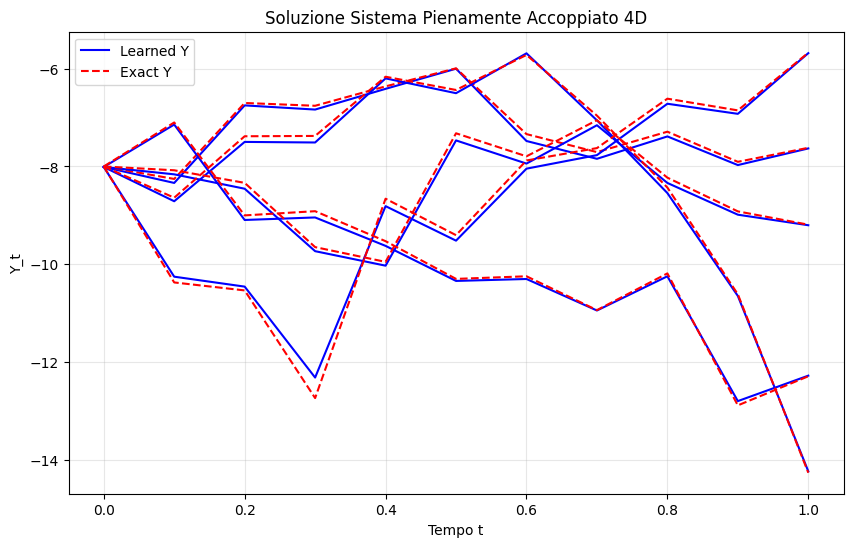

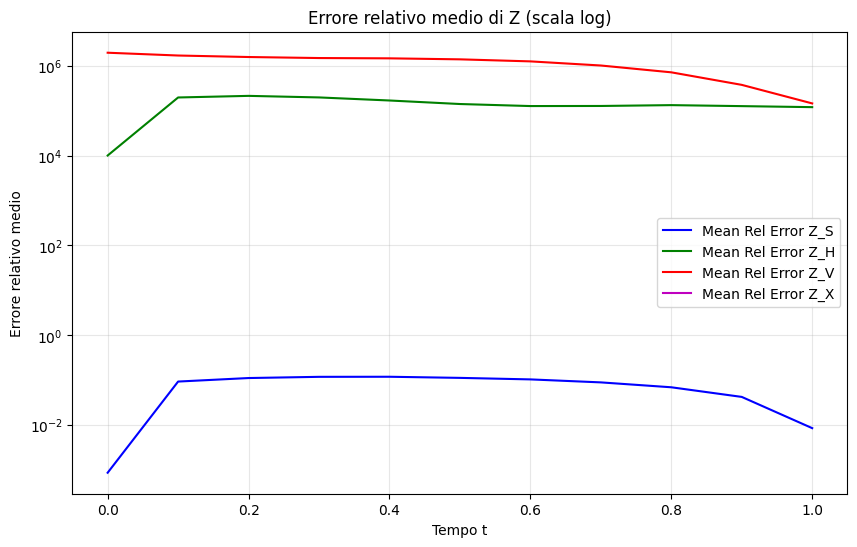

In [23]:
    # --- PLOTTING ---
    t_test, W_test = model.fetch_minibatch()
    X_pred, Y_pred, Z_pred = model.predict(Xi, t_test, W_test)

    def u_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]
        return -params['gamma'] * np.exp(S)*X_state

    def z_exact(t, Xi_arr):
        S = Xi_arr[:, 0:1]
        H = Xi_arr[:, 1:2]
        V = Xi_arr[:, 2:3]
        X_state = Xi_arr[:, 3:4]

        s1 = params['s1']
        s2 = params['s2']
        s3 = params['s3']

        common = np.exp(-t)
        z_s = -params['gamma'] * np.exp(S)*X_state * s1
        z_h = np.zeros_like(z_s)
        z_v = np.zeros_like(z_s)
        z_x = np.zeros_like(z_s)

        return np.concatenate([z_s, z_h, z_v, z_x], axis=1)

    Xi_reshaped = X_pred.reshape(-1, D)
    t_reshaped = t_test.reshape(-1, 1)

    Y_exact = u_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, 1)
    Z_exact = z_exact(t_reshaped, Xi_reshaped).reshape(M, N+1, D)

    exact_Y0 = u_exact(np.array([[0.0]]), Xi)[0, 0]
    print(f"\nPredicted Y0: {Y_pred[0,0,0]:.4f}")
    print(f"Exact Y0:     {exact_Y0:.4f}")

    plt.figure(figsize=(10,6))
    plt.plot(t_test[0,:,0], Y_pred[0,:,0], 'b', label='Learned Y')
    plt.plot(t_test[0,:,0], Y_exact[0,:,0], 'r--', label='Exact Y')
    plt.plot(t_test[1:5,:,0].T, Y_pred[1:5,:,0].T, 'b')
    plt.plot(t_test[1:5,:,0].T, Y_exact[1:5,:,0].T, 'r--')
    plt.title("Soluzione Sistema Pienamente Accoppiato 4D")
    plt.xlabel("Tempo t")
    plt.ylabel("Y_t")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Errore relativo medio sui componenti di Z (stile log_z, ma corretto per ogni componente)
    eps = 1e-8
    rel_err_Z = np.abs((Z_pred - Z_exact) / (np.abs(Z_exact) + eps))
    mean_rel_err_Z = np.mean(rel_err_Z, axis=0)  # (N+1, D)

    labels = ['Z_S', 'Z_H', 'Z_V', 'Z_X']
    colors = ['b', 'g', 'r', 'm']

    plt.figure(figsize=(10,6))
    for d in range(D):
        plt.plot(t_test[0,:,0], mean_rel_err_Z[:, d], colors[d], label=f'Mean Rel Error {labels[d]}')
    plt.yscale('log')
    plt.title('Errore relativo medio di Z (scala log)')
    plt.xlabel('Tempo t')
    plt.ylabel('Errore relativo medio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()